See [./Basics-Gaussian-Processes.ipynb](Basics-Gaussian-Processes.ipynb) for the first notebook in this series.

This notebook: adding noise to the 'observed' data and applying some optimization tricks

In [7]:
import pandas as pd  
import numpy as np
import sys,glob,os,time
import vaex
import math
import scipy


from multiprocessing import Pool, cpu_count
from tqdm.notebook import tqdm


import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import seaborn as sea 



%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%config IPCompleter.use_jedi = False

sea.set(font_scale=3,palette=sea.color_palette('colorblind'), 
        rc={'axes.facecolor':'white'},color_codes=False)
sea.set_style(style="ticks",rc={"xtick.direction": "in","ytick.direction": "in",
                                "xtick.minor.size": 4, "ytick.minor.size": 4})
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


pi = math.pi

We will assume that the data is described by a noiseless function $f(x)$ plus some independent Gaussian noise  
$\Large 
y = f(x) + \mathcal{N}(0,\sigma_y^2)
$

As a result, we will add our knowledge of the noise $\sigma_y$ (either from measurement or from prior) to the covariance matrix $K$  
$\Large 
{\rm cov}[y|X] = K + \sigma_y^2 I_N = K_y
$


In [12]:
# Test data
n = 500
Xtest = np.linspace(-5, 5, n).reshape(-1,1)

# Define the kernel function
def kernel(a, b, param):
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return np.exp(-.5 * (1/param) * sqdist)

param = 1
K_ss = kernel(Xtest, Xtest, param) 

The assumed kernel function above is  

$\Large
k(x,x^\prime,\ell) = \exp(-\frac{1}{2}\frac{(x-x^\prime)^2}{\ell^2}) 
$

Some relevant equations, derived from the conditional probabilities of multi-variate Gaussians  
$\Large
\begin{align}
p(f_s|X_s,X,f) &= \mathcal{N}(f_s|\mu_s,\Sigma_S) \\
\mu_s &= \mu(X_s) + K_S^T K_y^{-1}(f-\mu(X)) \\
\Sigma_s &= K_{ss} - K_s^T K_y^{-1} K_s
\end{align}
$  

where $\mu_s$ should be read as $\mu$ of $X_s$ given $X$, such that both $X$ and $X_s$ have means $\mu$ and $\mu_s$.

In this context, we assume there is a data set $D = \{(X,f)\} = \{(x_1, f_1),\dots,(x_N, f_N)\}$ and some unobserved data set that we are interested in $D_s = \{(X_s,f_s)\}$.

To simplify things and omit the usage of `np.linalg.inv` and rather make use of `np.linalg.solve`, let us define a matrix $L_k$ such that  
$\Large
\begin{align}
    L L_k = K_s \\
    L_k^T L_k = K_s^T K_y^{-1} K_s \\
    L_k^T L^{-1} f = K_s^T K_y^{-1}f
\end{align}
$  



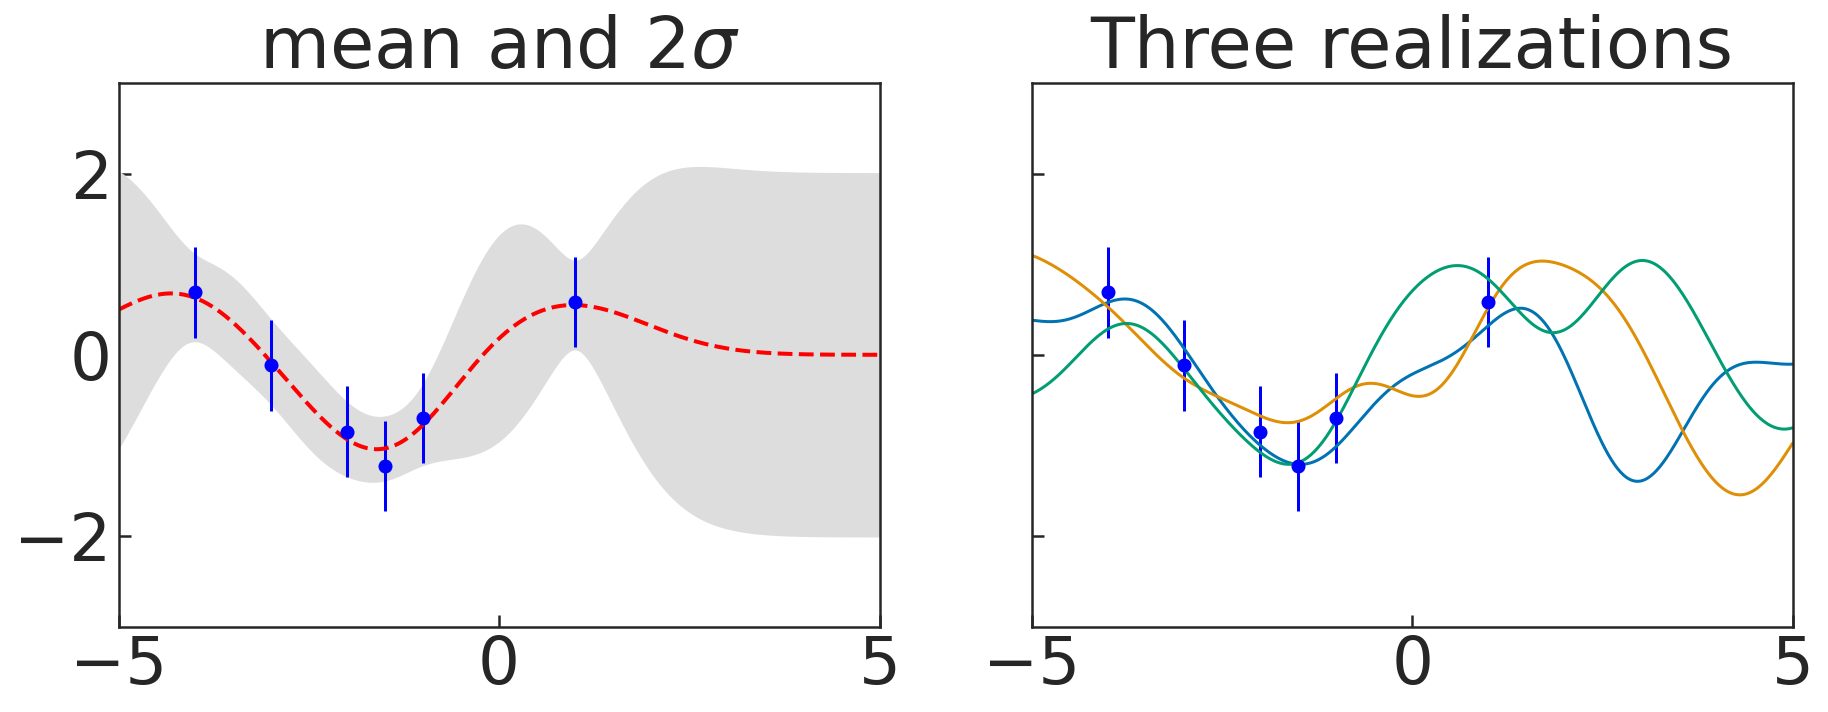

In [31]:
### Based on Katherine Bailey's code (modified)
# For a version with np.linalg.inv see below.

# Setting random state
rng = np.random.RandomState(41)

# Noiseless training data
sy = 0.25
Xtrain = np.array([-4, -3, -2, -1.5, -1, 1]).reshape(-1,1)
ytrain = np.sin(Xtrain) + rng.normal(scale=sy, size=Xtrain.shape)

# Apply the kernel function to our training points
K = kernel(Xtrain, Xtrain, param) + sy**2* np.eye(ytrain.shape[0])
L = np.linalg.cholesky(K + 1e-10*np.eye(len(Xtrain)))  # the small offset is added to make the algorithm converge


# Compute the mean at our test points.
K_s = kernel(Xtrain, Xtest, param)
Lk = np.linalg.solve(L, K_s)
iL_dot_f = np.linalg.solve(L, ytrain)

mu = np.einsum('ij,ik->j', Lk, iL_dot_f)

# Compute the standard deviation so we can plot it
S_s = K_ss - np.einsum('ij,ik->jk',Lk,Lk)
stdv = np.sqrt(S_s.diagonal())

# Sampling three curves given the posterior
L = np.linalg.cholesky(S_s + 1e-12*np.eye(n))
f_post = mu.reshape(-1,1) + np.dot(L, rng.normal(size=(n,3)))


fig, axes = plt.subplots(ncols=2, figsize=(15,5), sharex=True, sharey=True)

plt.sca(axes[0])
plt.errorbar(Xtrain, ytrain, yerr=0.5, fmt='o', color='b')
plt.gca().fill_between(Xtest.flat, mu-2*stdv, mu+2*stdv, color="#dddddd")
plt.plot(Xtest, mu, 'r--', lw=2)
plt.axis([-5, 5, -3, 3])
plt.title(r'mean and $2\sigma$')

plt.sca(axes[1])
plt.errorbar(Xtrain, ytrain, yerr=0.5, fmt='o', color='b')
plt.plot(Xtest, f_post)
plt.title('Three realizations')

plt.show()

### How to fit the widht of the kernel length $\ell$: MLE

The log-likelihood of the data $p(y|X)$ is given by (simply that of a Gaussian with zero mean)

$\Large
\log p(y|X) = \log\mathcal{N}(y|0,K_y) = -\frac{1}{2}y^T K_y^{-1} y - \frac{1}{2}\log\det{K_y} - \frac{N}{2}\log2\pi
$


and the gradient of the log-likelihood with respect to $\theta = \ell$ is given by

$\Large
\frac{\partial}{\partial\theta}\log p(y|X) = \frac{1}{2} y^T K_y^{-1} \frac{\partial K_y}{\partial \theta} K_y^{-1} y - \frac{1}{2}{\rm tr}(K_y^{-1}\frac{\partial K_y}{\partial \theta})
$

### Takeaway points
NB: Based on Nando's lecture

GP a distribution of kernels:  
In the case of a single data point: superimpose the prior mean with a single kernel function centred at the data point. So a GP is an ensemble of kernel functions based on the locations (and uncertainties) of the observed data. In other words, fitting a GP is fitting a non-linear combination of basis functions (i.e. the kernels).

References:
* https://katbailey.github.io/post/gaussian-processes-for-dummies/
* https://peterroelants.github.io/posts/gaussian-process-tutorial/
* https://en.wikipedia.org/wiki/Gaussian_process
* Lectures from Nando de Freitas [see youtube](https://www.youtube.com/watch?v=MfHKW5z-OOA&list=PLE6Wd9FR--EdyJ5lbFl8UuGjecvVw66F6&index=9)